In [34]:
import numpy as np
import pandas as pd
import pickle, csv
import os

from keras.models import Sequential, load_model, Model
from keras.layers import LSTM, Dense, Dropout, Input, concatenate, Flatten, Reshape,MaxPooling2D, Conv2D, TimeDistributed
from keras import regularizers
from keras.utils import to_categorical

from keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam
from keras.preprocessing.sequence import TimeseriesGenerator
import tensorflow.keras.backend as K
from skimage.transform import resize
from tensorflow.keras import layers, models


from matplotlib import pyplot as plt
from matplotlib import style
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
import seaborn as sns

import tensorflow.keras.backend as K
K.clear_session()

In [35]:
# Load powerprice data and format it
df_powerprice = pd.read_csv("data/PowerPrice.csv")
df_powerprice["Time"] = pd.to_datetime(df_powerprice["Time"], infer_datetime_format=True)
df_powerprice = df_powerprice.drop(columns=["Time"])
df_powerprice

,DayAhead,Spot,REBAP
0,2.83200,3.688,-4.566
1,2.37575,4.245,-13.964
2,1.91950,3.161,0.345
3,1.46325,1.664,3.048
4,1.00700,3.110,-6.679
...,...,...,...
35035,3.77625,3.342,4.856
35036,3.73900,4.425,8.561
35037,3.70175,2.473,6.076
35038,3.66450,3.241,11.797


In [36]:
# Load spatial data and format it
datasets = []
for filename in os.listdir("data/Spatial"):
    if filename.endswith(".pickle"):
        with open(os.path.join("data/Spatial", filename), "rb") as file:
            data = pickle.load(file)
            if data.shape == (100, 35040):
                datasets.append(data)
                print(filename)
            else:
                print(f"Skipping {filename}: unexpected shape {data.shape}")

biogas_kw_2019.pickle
brown_coal_kw_2019.pickle
completed_solar_kw_2019.pickle
completed_wind_onshore_kw_2019.pickle
demand_kw_2019.pickle
hard_coal_kw_2019.pickle
nuclear_kw_2019.pickle
oil_kw_2019.pickle
water_laufwasser_kw_2019.pickle
water_pumpspeicher_PB_kw_2019.pickle
water_pumpspeicher_TB_kw_2019.pickle
water_speicherwasser_kw_2019.pickle
wind_offshore_kw_2019.pickle


In [37]:
# Convert the list of arrays to a 3D array
spatial_data = np.stack(datasets, axis=0)

spatial_data = spatial_data.reshape((spatial_data.shape[0], spatial_data.shape[1], spatial_data.shape[2]))

# transpose the second and third dimensions to get shape (13, 35040, 100)
spatial_data = spatial_data.transpose((0, 1, 2))

spatial_data.shape

(13, 100, 35040)

In [38]:
# Load mask and reshape to match desired output shape
mask = pd.read_csv("germany/mask.csv", header=None).values
#mask = mask_df.values.reshape((40, 40, 1))

mask.shape

(30, 30)

In [39]:
spatial_data.shape

(13, 100, 35040)

In [40]:
image_all = np.zeros((35040, 30, 30, 13))
for j in range(spatial_data.shape[2]):
    for i in range(spatial_data.shape[0]):
        image = np.zeros((30, 30))
        for s in range(spatial_data.shape[1]):
            image[mask == s] = spatial_data[i,s,j]
        #print(i)
        image_all[j, :, :, i] = image

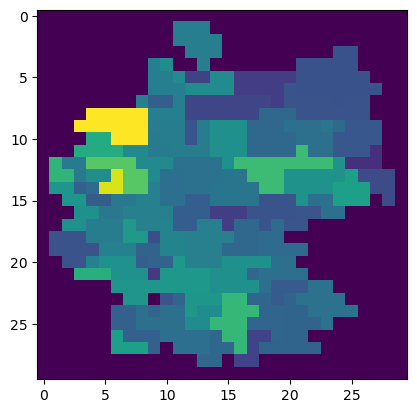

In [41]:
plt.imshow(image_all[35030,:,:,4])
plt.show()

In [42]:
image_all.shape

(35040, 30, 30, 13)

In [64]:
#input_2 = df_powerprice["DayAhead"].values.reshape((-1, 4))
#input_2.shape

In [65]:
output = df_powerprice["Spot"].values

output.shape

(35040,)

In [66]:
def split_datasets(df, df2, window_size, look_ahead):
    X = []
    y = []
    for i in range(len(df) - window_size - look_ahead + 1):
        row = df[i:i+window_size, :, :, :]
        X.append(row)
        label = df2[i+window_size+look_ahead-1]
        y.append(label)
    return np.array(X), np.array(y)

In [67]:
window_size = 4
look_ahead = 1
X, y = split_datasets(image_all, output, window_size=window_size, look_ahead=look_ahead)

print(f"X shape: {X.shape}, y shape: {y.shape}")

X shape: (35036, 4, 30, 30, 13), y shape: (35036,)


In [68]:
# Split the data into train, validation, and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=50)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.3, random_state=50)

print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_val shape:", X_val.shape)
print("y_val shape:", y_val.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)

X_train shape: (19619, 4, 30, 30, 13)
y_train shape: (19619,)
X_val shape: (8409, 4, 30, 30, 13)
y_val shape: (8409,)
X_test shape: (7008, 4, 30, 30, 13)
y_test shape: (7008,)


In [69]:
# Reshape the input array to a 2D array
input_2d = X_train.reshape(-1, X_train.shape[-1])

# Scale the array using MinMaxScaler
scaler = MinMaxScaler()
input_scaled = scaler.fit_transform(input_2d)

# Reshape the scaled array back to the original shape
X_train = input_scaled.reshape(X_train.shape)

print("Scaled X shape:", X_train.shape)

Scaled X shape: (19619, 4, 30, 30, 13)


In [70]:
scaler_y_train = MinMaxScaler()
y_train = scaler_y_train.fit_transform(y_train.reshape(-1, 1))
y_train.shape

(19619, 1)

In [71]:
# Reshape the input array to a 2D array
input_2d = X_val.reshape(-1, X_val.shape[-1])

# Scale the array using MinMaxScaler
scaler_x_val = MinMaxScaler()
input_scaled = scaler_x_val.fit_transform(input_2d)

# Reshape the scaled array back to the original shape
X_val = input_scaled.reshape(X_val.shape)

print("Scaled X shape:", X_val.shape)

Scaled X shape: (8409, 4, 30, 30, 13)


In [72]:
scaler_y_val = MinMaxScaler()
y_val = scaler_y_val.fit_transform(y_val.reshape(-1, 1))
y_val.shape

(8409, 1)

In [73]:
time_steps = 4
width = 30
height = 30
channel = 13

# Define the input layer
input_layer = Input(shape=(time_steps, width, height, channel))

# Define the convolutional layers
cnn1 = Conv2D(filters=16, kernel_size=(3, 3), activation='relu')
cnn2 = MaxPooling2D(pool_size=(2, 2))
cnn3 = Conv2D(filters=32, kernel_size=(3, 3), activation='relu')
cnn4 = MaxPooling2D(pool_size=(2, 2))

# Apply TimeDistributed to the convolutional layers
td_cnn1 = TimeDistributed(cnn1)(input_layer)
td_cnn2 = TimeDistributed(cnn2)(td_cnn1)
td_cnn3 = TimeDistributed(cnn3)(td_cnn2)
td_cnn4 = TimeDistributed(cnn4)(td_cnn3)

# Reshape the output of the convolutional layers
reshaped = Reshape((-1, 6*6*32))(td_cnn4)

# Apply TimeDistributed Dense layer
td_fcnn = TimeDistributed(Dense(10, activation='relu', name='output'))(reshaped)

# Apply LSTM layer
lstm_output = LSTM(1, name='lstm1_1')(td_fcnn)

# Create the model
model = Model(inputs=input_layer, outputs=lstm_output)

# Print the model summary
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 4, 30, 30, 13)]   0         
                                                                 
 time_distributed_5 (TimeDis  (None, 4, 28, 28, 16)    1888      
 tributed)                                                       
                                                                 
 time_distributed_6 (TimeDis  (None, 4, 14, 14, 16)    0         
 tributed)                                                       
                                                                 
 time_distributed_7 (TimeDis  (None, 4, 12, 12, 32)    4640      
 tributed)                                                       
                                                                 
 time_distributed_8 (TimeDis  (None, 4, 6, 6, 32)      0         
 tributed)                                                 

In [74]:
# Compile the model with an appropriate optimizer and loss function

model.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.0001), metrics=[RootMeanSquaredError()])

In [75]:
# Define callbacks for early stopping and checkpoint saving
es = EarlyStopping(monitor='val_loss', patience=12, verbose=1, restore_best_weights=True)

In [76]:
cp = ModelCheckpoint(filepath="training/cnn-lstm/model3.h5", 
                      save_best_only=True,
                      monitor='val_loss', 
                      mode='min', 
                      save_weights_only=False, 
                      verbose=1)

In [ ]:
# Fit the model on the training data
history = model.fit(X_train, y_train, batch_size=50, epochs=1000, validation_data=(X_val, y_val), callbacks=[cp, es])

In [ ]:
#Plot the training and validation loss

plt.figure(figsize=(10,5))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

In [ ]:
# Get the training and validation accuracy values from the history object
train_acc = history.history['root_mean_squared_error']
val_acc = history.history['val_root_mean_squared_error']

# Create a plot of training and validation accuracy
epochs = range(1, len(train_acc) + 1)
plt.figure(figsize=(10,5))
plt.plot(epochs, train_acc, 'b', label='Training RMSE')
plt.plot(epochs, val_acc, 'r', label='Validation RMSE')
plt.title('Training and Validation Root Mean Squared Error')
plt.xlabel('Epoch')
plt.ylabel('RMSE')
plt.legend()
plt.show()

In [ ]:
# After training, print actual and predicted values for the validation data
y_val_pred = model.predict(X_val)
print("Actual\t\tPredicted")
for i in range(len(y_val)):
    print(f"{y_val[i]}\t{y_val_pred[i]}")

In [ ]:
# Define the preprocess_input_data function
def preprocess_input_data(input_data):
    # Create a MinMaxScaler instance
    scaler = MinMaxScaler()

    # Reshape the input data to a 2D array
    input_2d = input_data.reshape(-1, input_data.shape[-1])

    # Apply the scaler to the input data
    input_scaled = scaler.fit_transform(input_2d)

    # Reshape the scaled data back to the original shape
    preprocessed_input = input_scaled.reshape(input_data.shape)

    # Return the preprocessed input data
    return preprocessed_input

In [ ]:
# Dummy input data with shape (4050, 4, 30, 30, 13)
input_data = np.random.rand(4050, 4, 30, 30, 13)

# Preprocess the input data
preprocessed_input = preprocess_input_data(input_data)

# Load the trained model
model.load_weights("training/cnn-lstm/")  # Provide the path to the trained model weights

# Make predictions
predictions = model.predict(preprocessed_input)

# Access the predicted values
result = predictions.flatten()  # Flatten the predictions array to obtain a 1D array of predicted values

# Print the shape and the values of the result array
print("Result shape:", result.shape)
print("Predicted values:", result)

In [ ]:
y_val.shape

In [ ]:
y_val_pred.shape